### Installation of required packages

In [19]:
! pip install psutil pandas pynvml tqdm line_profiler matplotlib seaborn
! pip install pyahocorasick Bio pybmoore ahocorasick_rs

# pip install requirements.txt

### bash commands makeblastdb and blastp must be installed and on PATH
# sudo apt update
# sudo apt install ncbi-blast+

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Imports and initialization

In [20]:
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

from Bio import SeqIO

import tempfile

#boyer moore specific imports
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

### Data for benchmarking

# Peptide and proteome data loading - IF BENCHMARKING ON EXISTING DATA

In [21]:
def load_peptides_txt(path):
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

def load_proteome_fasta(path):
    """
    Retourne une liste de tuples (protein_id, sequence)
    """
    return [(rec.id, str(rec.seq)) for rec in SeqIO.parse(path, "fasta")]

peptides = load_peptides_txt("Peptides.txt")

proteome = load_proteome_fasta(
    "uniprotkb_proteome_UP000000803_2025_11_25.fasta"
)

proteome_fasta_path = "uniprotkb_proteome_UP000000803_2025_11_25.fasta"

# Boyer-Moore expects (id, seq)
queries = [(pep, pep) for pep in peptides]  # id = sequence

# Creation of a temporary fasta file for the proteome
proteome_fasta_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta')
records = [SeqRecord(Seq(seq), id=pid) for pid, seq in proteome]
SeqIO.write(records, proteome_fasta_file.name, "fasta")
proteome_fasta_file.close()


# Random data from data_generator.py - GENERATING DATA TO BENCHMARK 

In [ ]:
### WIP

from data_generator import generate_benchmark_database

# Generate random data for benchmarking
peptides = generate_random_peptides(num_peptides=100, peptide_length_range=(5, 20))
proteome = generate_random_proteome(num_sequences=50, sequence_length_range=(100, 500))

# Boyer-Moore expects (id, seq)
queries = [(pep, pep) for pep in peptides]  # id = sequence

# Creation of a temporary fasta file for the generated proteome
proteome_fasta_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta')
records = [SeqRecord(Seq(seq), id=f"seq_{i}") for i, (pid, seq) in enumerate(proteome)]
SeqIO.write(records, proteome_fasta_file.name, "fasta")
proteome_fasta_file.close()

# Set path to the temporary fasta file
proteome_fasta_path = proteome_fasta_file.name

### Matching algorithms to benchmark 

In [24]:
from bench_functions import (
    run_ahocorasick_mem,
    run_ahocorasick_rs_mem,
    run_find_mem,
    run_in_mem,
    run_blast_mem,
    run_boyermoore_parallel_mem,
    run_grawk_mem2
    )


TESTS = [
    (run_ahocorasick_mem, (peptides, proteome)),  # tuple -> argument
    (run_ahocorasick_rs_mem, (peptides, proteome)),
    (run_find_mem, (peptides, proteome)),
    (run_in_mem, (peptides, proteome)),
    (run_blast_mem, (peptides, proteome_fasta_path)),
    (run_boyermoore_parallel_mem, (queries, proteome_fasta_file.name)),
    (run_grawk_mem2, (peptides, proteome))
]

In [26]:
# Check WSL availability
#if platform.system() == "Windows":
    #try:
        #subprocess.run(["wsl", "--version"], capture_output=True, check=True, timeout=5)
        #TESTS.append((run_grawk_mem_wsl, (peptides, proteome)))
        #print("✓ WSL detected")
    #except (FileNotFoundError, subprocess.TimeoutExpired):
        #print("⚠ WSL not available - skipping grawk_mem_wsl")

In [27]:
# Logging configuration: write execution details to a log file
logging.basicConfig(
    filename="benchmark.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

process = psutil.Process()

### Single-run measurement utility

In [28]:
def run_once(fn, *args, **kwargs):
    """
    Execute a function once and collect basic timing and memory information.
    This is decorator-free to ensure functions remain pickleable.
    """
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()

    mem = process.memory_info().rss / 1e6

    return {
        "time_seconds": t1 - t0,
        "memory_used_MB": mem,
        "result": result
    }

### Multi-run wrapper (manual loop)

In [29]:
def benchmark(fn, runs=5, args=()):
    """
    Run a function several times with positional arguments and compute average runtime.
    No decoration or wrapping done, to keep fn pickleable.
    """
    records = []
    for _ in range(runs):
        rec = run_once(fn, *args)  # unpacks the tuple
        records.append(rec)

    avg_time = sum(r["time_seconds"] for r in records) / len(records)

    return {
        "function": fn.__name__,
        "args": args,
        "time_mean": avg_time,
    }



### Sequential execution 

In [30]:
results_seq = []
for fn, params in TESTS:
    res = benchmark(fn, runs=5, args=params)  # <- args=params, no *
    logging.info(f"[SEQ] {res}")
    results_seq.append(res)

df_seq = pd.DataFrame(results_seq)
df_seq


,function,args,time_mean
0,run_ahocorasick_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",0.316262
1,run_ahocorasick_rs_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",0.157464
2,run_find_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",2.248042
3,run_in_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",1.812342
4,run_blast_mem,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",6.826219
5,run_boyermoore_parallel_mem,"([(LNIPVSEVNPR, LNIPVSEVNPR), (EVSGDASEAALLK, ...",21.839639
6,run_grawk_mem2,"([LNIPVSEVNPR, EVSGDASEAALLK, VIMVTGDHPITAK, D...",2.382912


### Metrics

In [31]:
def run_single_with_metrics(test):
    func, args = test # args can be a tuple or a dict
    if isinstance(args, dict):
        args = (args.get("size", 0),)  # -> tuple
    elif not isinstance(args, tuple):
        args = (args,)  # transform in tuple if only 1 argument

    proc = psutil.Process(os.getpid())
    cpu_start = psutil.cpu_percent(interval=None)
    mem_start = proc.memory_info().rss / (1024*1024)  # MB

    import time
    start = time.time()
    result = func(*args)
    end = time.time()

    cpu_end = psutil.cpu_percent(interval=None)
    mem_end = proc.memory_info().rss / (1024*1024)  # MB

    return {
        "result": result,
        "time_sec": end - start,
        "cpu_mean": cpu_end - cpu_start,
        "mem_mean_MB": mem_end - mem_start
    }

### DataFrame creation

In [32]:
# parallel execution with ThreadPoolExecutor (safe in Jupyter)
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single_with_metrics, TESTS))

df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": [r["result"] for r in results],
    "time_sec": [r["time_sec"] for r in results],
    "cpu_mean": [r["cpu_mean"] for r in results],
    "mem_mean_MB": [r["mem_mean_MB"] for r in results]
})

print(df_parallel.columns)



Index(['function', 'argument', 'result', 'time_sec', 'cpu_mean',
       'mem_mean_MB'],
      dtype='object')


### Visualisation of results (boxplot + violin)

<Figure size 640x480 with 0 Axes>

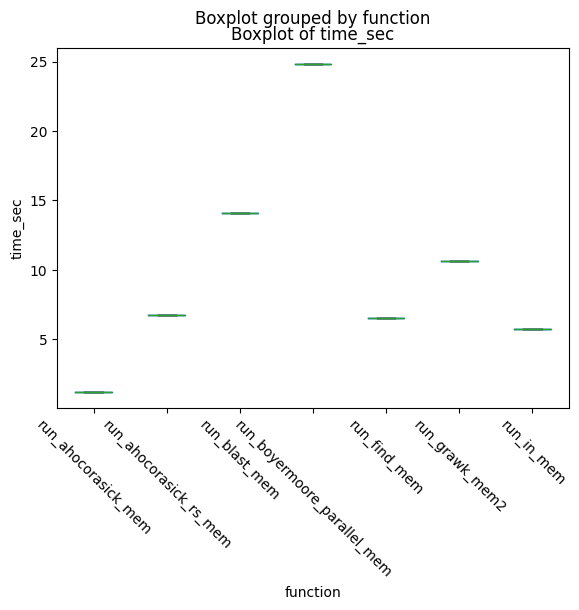

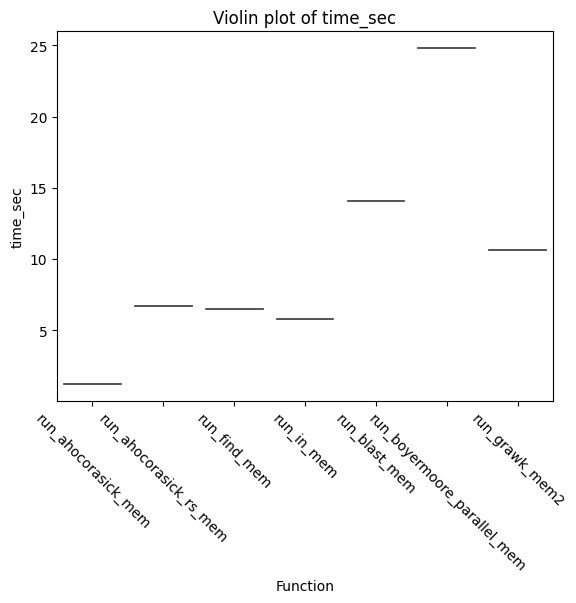

<Figure size 640x480 with 0 Axes>

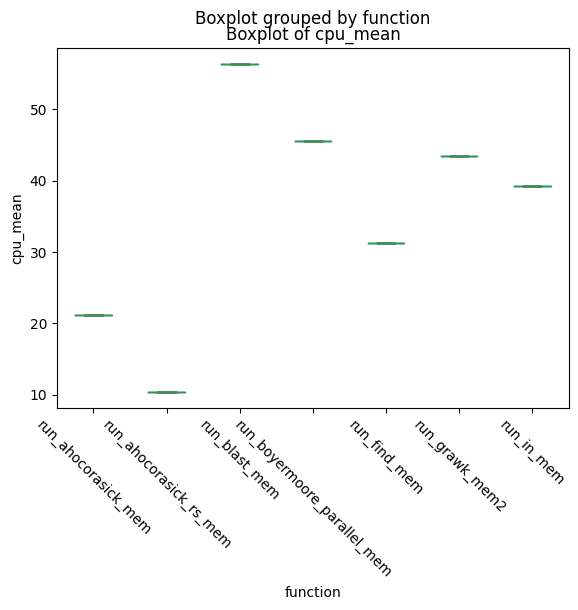

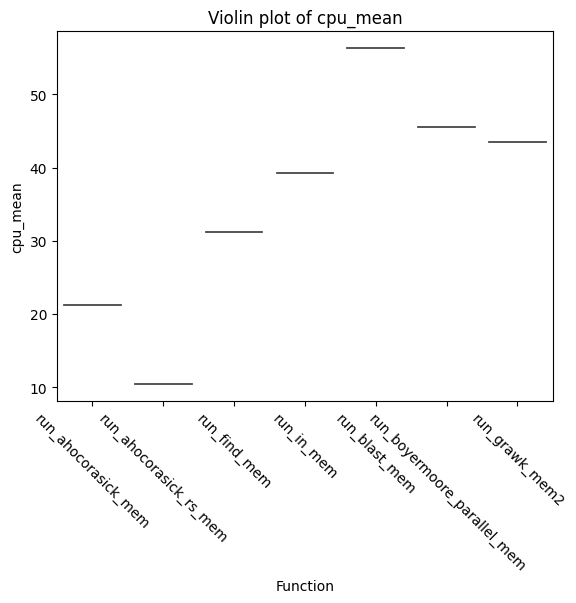

<Figure size 640x480 with 0 Axes>

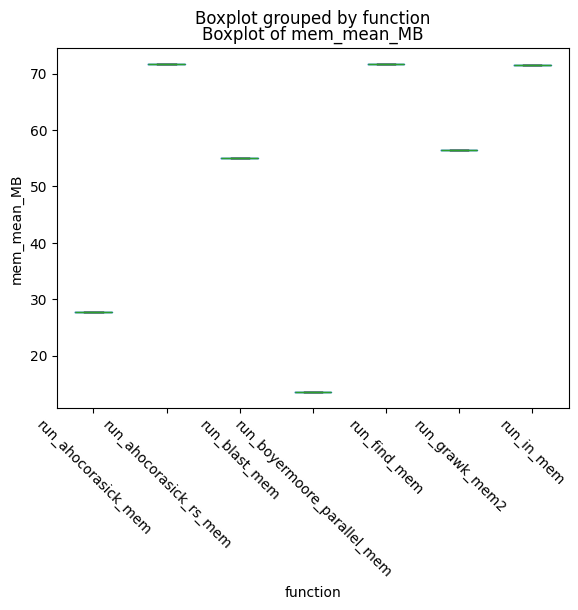

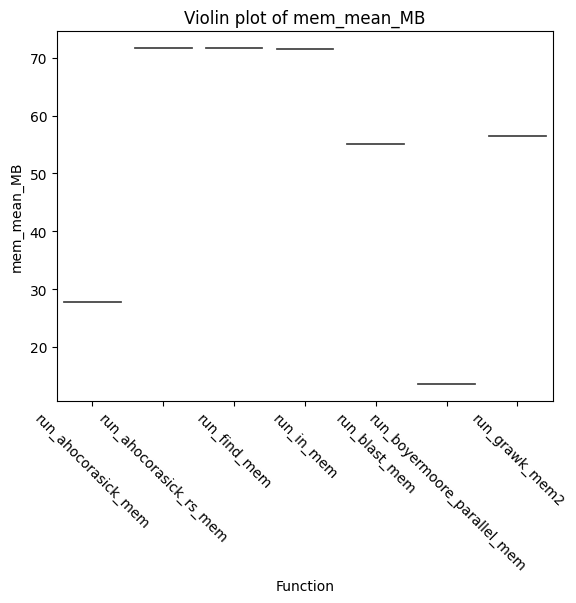

In [33]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

for m in metrics:
    # Boxplot with Pandas
    plt.figure()
    ax = df_parallel.boxplot(column=[m], by="function", grid=False)
    plt.title(f"Boxplot of {m}")
    plt.xlabel("function")
    plt.ylabel(m)
    plt.xticks(rotation=-45)
    plt.show()

    # Violin plot with Seaborn
    plt.figure()
    ax = sns.violinplot(x="function", y=m, data=df_parallel)
    plt.title(f"Violin plot of {m}")
    ax.set_xlabel("Function")
    ax.set_ylabel(m)
    plt.xticks(rotation=-45)
    plt.show()


### Export results

In [34]:
df_seq.to_csv("bench_seq.csv", index=False)
df_parallel.to_csv("bench_parallel.csv", index=False)
print("Benchmark exports complete.")


Benchmark exports complete.
